# Plotting DVL and Slocum Glider Data with Pandas & Seaborn

---
## Import Libraries

In [49]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries
import PathfinderUtils
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(PathfinderUtils)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)

---
## 0. Load or Parse Flight Computer Data

In [3]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


---
## 1. Load or Parse DVL data 

In [4]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)

#################################################
# File ID Number ################################
#################################################
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14

#################################################
# Parse Selected File IDs #######################
#################################################
ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)

#################################################
# Frontiers (and Thesis) Naming Convention ######
#################################################
tsa  = ts14
tsb  = ts12 # (no bottom)
tsc  = ts2  # (no bottom)
tsd  = ts3 
tse  = ts4
tsf  = ts5
tsg  = ts7 # (not included in Frontiers)
tsh  = ts9 # (not included in Frontiers)

#################################################
# JFR Naming Convention #########################
#################################################
# tsa  = ts14
# tsb  = ts5
# tsc  = ts4
# tsd  = ts3
# tse  = ts7

________________________________________
- Parsing DVL File ---------------------
    input file: sk211652.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
    # ensembles:   2600
    # ensembles:   2800
    # ensembles:   3000
    # ensembles:   3200
    # ensembles:   3400
- Parsing Complete ---------------------
    # ensembles:   3442
    parsing time:  13.064793
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords
________________________________________
- Parsing DVL File ---------------------
    input file: 01820

---
## 2. Determine Water Column Currents from DVL data 

In [14]:
ts = tsb

In [15]:
reload_modules()

# tuning parameters for working with DVL data 
pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
# voc_mag_filter       =  0.5  # [m/s]   filter out ocean current 
# voc_delta_mag_filter =  0.3  # [m/s]   filter out deltas between layers
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5
# [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = PathfinderUtils.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = PathfinderUtils.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = PathfinderUtils.OceanCurrent()

    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [PathfinderUtils.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
# print(water_column.averages_to_str())

> Finished Estimating Water Column Currents!


---
## 3. Use Water Column Currents to Improve Odometry

In [16]:
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]

# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    
    # retrieve ocean current estimate from water column 
    voc_u = voc_u_list[int(depth)]
    voc_v = voc_v_list[int(depth)]

    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t

    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t

    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
## Plotting: Improved Odometry and Water Column Currents

### DVL Odometry

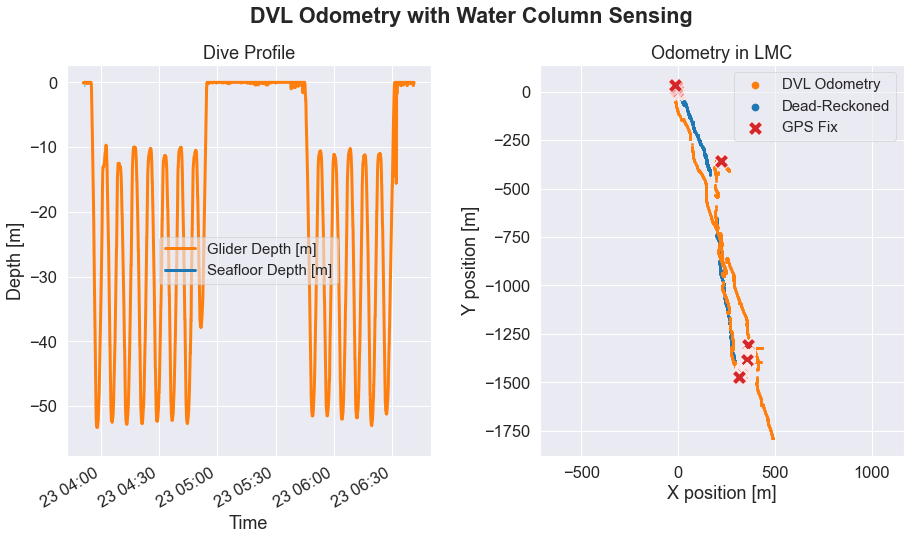

In [17]:
reload_modules()
dvl_plotter.plot_profile_and_odometry_and_dr(ts, ts_flight_kolumbo_all, save_name='tmp-profile.png')

### Water Column Currents

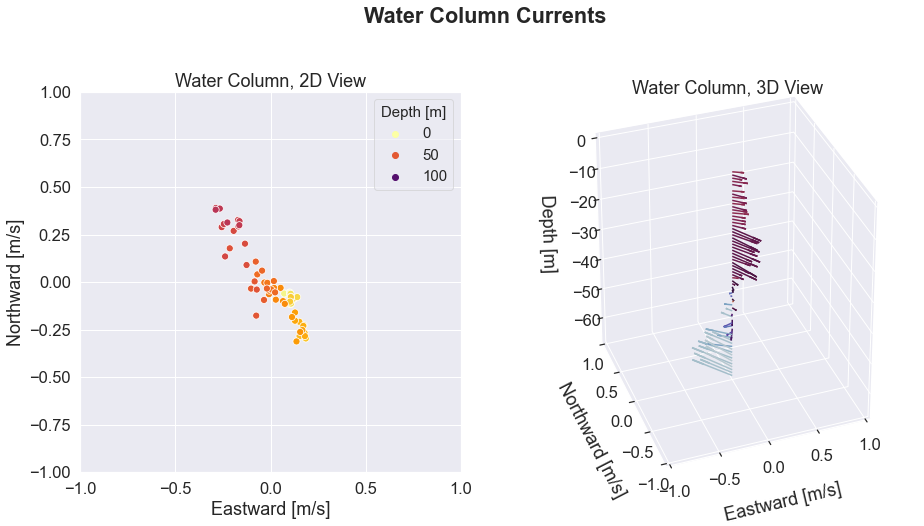

In [18]:
reload_modules()
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, voc_z_list, save_name='tmp-water-column.png')

---
# Glider Simulation Code

## 1) Define ocean current conditions

In [35]:
dive_b_depth   = 70
arctic_depth   = 80
strawman_voc_u = [voc_u_list[int((dive_b_depth/arctic_depth)*i)] for i in range(arctic_depth)]
strawman_voc_v = [voc_v_list[int((dive_b_depth/arctic_depth)*i)] for i in range(arctic_depth)]
strawman_voc_z = np.linspace(0,arctic_depth,arctic_depth)
strawman_voc_m = [np.linalg.norm([strawman_voc_u[i], strawman_voc_v[i]]) for i in range(len(strawman_voc_u))]

# fill NaN values 
for i in range(len(strawman_voc_u)):
    if np.isnan(strawman_voc_u[i]):
        strawman_voc_u[i] = strawman_voc_u[i-1]
        strawman_voc_v[i] = strawman_voc_v[i-1]
        
scaling_factor = 1
strawman_voc_u = list(np.array(strawman_voc_u)*scaling_factor)
strawman_voc_v = list(np.array(strawman_voc_v)*scaling_factor)


# fig = plt.subplots(figsize=(15,8))
# sns.scatterplot(strawman_voc_u, -strawman_voc_z, label='Eastward Velocity [m/s]')
# sns.scatterplot(strawman_voc_v, -strawman_voc_z, label='Northward Velocity [m/s]')
# sns.scatterplot(strawman_voc_m, -strawman_voc_z, label='Magnitude Velocity [m/s]')
# plt.xlabel('Ocean Current [m/s]')
# plt.ylabel('Depth [m]')

cum_u, cum_v = 0,0
count = 0

for i in range(len(strawman_voc_u)):
    if not np.isnan(strawman_voc_u[i]):
        cum_u += strawman_voc_u[i]
        cum_v += strawman_voc_v[i]
        count += 1

avg_voc_u, avg_voc_v = cum_u/count, cum_v/count
avg_voc_mag = np.linalg.norm([avg_voc_u, avg_voc_v])
avg_voc_ang = np.arctan2(avg_voc_u, avg_voc_v)
print(avg_voc_mag)
print(avg_voc_ang*180/np.pi)
print(avg_voc_ang*180/np.pi - -90)
print(avg_voc_ang*180/np.pi - -28.85)

0.010567717808048537
177.80194068895725
267.80194068895725
206.65194068895724


## 2) Define waypoint list

In [30]:
def get_distance(waypoint1, waypoint2):
    delta_x = waypoint2[0]-waypoint1[0]
    delta_y = waypoint2[1]-waypoint1[1]
    return(np.linalg.norm([delta_x, delta_y]))

def get_heading(waypoint1, waypoint2):
    delta_x = waypoint2[0]-waypoint1[0]
    delta_y = waypoint2[1]-waypoint1[1]
    return(np.arctan2(delta_x, delta_y))

energy_supply = 10*1000 # Whr

# mission from Kotzebue 
waypoints     = [(0,0), (-215000, 0), (-315000,185000), (-315000,1210000), (-315000,185000), (-215000,0), (0,0)]

# mission from Barrow (first mission)
waypoints     = [(579598-579598, 7912458-7912458), (412541-579598,  8124731-7912458), (518537-579598, 8661887-7912458), (412541-579598,  8124731-7912458), (579598-579598, 7912458-7912458)]

# mission from Barrow (second mission)
waypoints     = [(568824-568824, 7923411-7923411), (546996-568824, 8267564-7923411), (528927-568824, 8377622-7923411), (546996-568824, 8267564-7923411), (568824-568824, 7923411-7923411)]

dist_list = [get_distance(waypoints[i], waypoints[i+1]) for i in range(len(waypoints)-1)]
strawman_range = sum(dist_list) # [m]
strawman_range/1000

912.7518479414969

## 3) Define propulsive functions

In [43]:
DEG_TO_RAD       = np.pi/180
HOURS_TO_SECONDS = 60*60


def get_prop_power(v):
    '''Determines propulsive power needed to achieve through-water speed v, old model.
    '''
    c1 = 0.450 
    c2 = 0.385
    return((v/c1)**(1/c2))


def get_buoyancy_power(pitch, depth_band, gamma, vtw_total):
    '''TODO
    '''
#     # OLD buoyancy power function
#     inflection_energy = 2.95 # Whrs
#     DEG_TO_RAD = np.pi/180
#     S_TO_HOUR  = 1/3600
#     return (gamma*inflection_energy / ((2*depth_band / np.tan(pitch*DEG_TO_RAD))*S_TO_HOUR))
    E_PUMP = 2.95*60*60
    DEG_TO_RAD = np.pi/180
    if pitch == 0:     return(0)
    if vtw_total <= 0: return(np.nan) # TODO
    # if vtw_total <= 0: return(0)
    vtw_vertical = vtw_total*np.sin(pitch*DEG_TO_RAD)
    delta_time_inflection  = 2*depth_band/vtw_vertical
    return(gamma*E_PUMP / delta_time_inflection)
    
    
def get_controller_power(prop_power):
    '''Determines motor controller loss as a function of input controller power
    '''
    c1 = 0.10 
    c0 = 0.32
    return(prop_power*c1 + c0)


def get_thruster_power(v):
    '''Determine total thruster power as sum of propellor power and controller power
    '''
    p_prop = get_prop_power(v)
    p_controller = get_controller_power(p_prop)
    return(p_prop + p_controller)


def get_opt_v(v_list, c, d, h, E, pitch=12, depth_band=500, gamma=1):
    """Return optimal velocity from list of velocities given other operating conditions. 
    
    Args:
        v_list: list of possible velocity values to choose from 
        c: ocean current speed (magnitude)
        d: angle of ocean current relative to glider heading (heading of travel)
        h: hotel load of the vehicle 
        E: energy capacity of the vehicle (used for computing range)
        model_num: the glider efficiency model to use in the computation
    """
    r_list  = [get_range(g, c, d, h, E, pitch, depth_band, gamma) for g in v_list]
    max_idx = np.nanargmax(r_list)
    max_r   = r_list[max_idx]
    opt_v   = v_list[max_idx]
    return(opt_v)


def get_range(v_g, v_c, delta, p_hotel, E, pitch=12, depth_band=500, gamma=1):
    """Computes the range that can be achieved given the state variables.
    
    Args: 
        i: input current in [Amps]
        v_current: ocean current speed magnitude in [m/s]
        delta: angle between heading and v_current [rad]
        hotel: all non-propulsive power [Amps]
        E: total energy capacity [Amp-Hours]
        pitch: pitch angle of glider [deg]
        depth_band: depth band of the glider [m]
        model_num: the glider efficiency model to use in the computation
    """
    v_c_para    =  v_c*np.cos(delta)
    v_c_perp    =  np.abs(v_c*np.sin(delta))
    
    # glider cannot overcome side-slipe ocean current 
    if v_g < v_c_perp:
        return(np.NaN)
    
    # glider cannot overcome adverse parallel currents
    v_para  = (v_g**2 - v_c_perp**2)**0.5
    if v_para < -v_c_para:
        return(np.NaN)
    
    # glider can succesfully move in intended direction
    # get propulsive power for given velocity using appropriate model
    v_total     = v_para + v_c_para
    p_thruster  = get_thruster_power(v_g)
    p_buoyancy  = get_buoyancy_power(pitch, depth_band, gamma, v_g)
    p_total     = p_thruster + p_hotel + p_buoyancy
    t_total = (E*HOURS_TO_SECONDS)/(p_total)
    return (v_total*t_total)

In [44]:
p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97

p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

In [57]:
###########################################
# CONSTANTS 
# # these values are from the glider spreadsheet document 
# p_buoyancy_26deg_50m = 11.03   # Whr/km
# p_buoyancy_12deg_50m =  5.75   # Whr/km
# p_buoyancy_12deg_25m =  6.88   # Whr/km

buoyant_26deg_speed  = 0.37    # m/s
buoyant_12deg_speed  = 0.26    # m/s

p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97

p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

# amount of buoyancy engine power (and speed) reduced
buoyancy_reduction       = 0.2  # value deduced after discussing with Rich 

# I forget what this comes from, but I think it is from the range achieved with control policy A
baseline_range = 895225.095

# function handle for AVC
# get_opt_v(v_list, c, d, h, E, pitch=12, depth_band=500, gamma=1)


res = 200
v_list = np.linspace(0,1.0,res)
# hybrid_constant_speed_transit_vtw = get_opt_v(v_list, 0, 0, p_hotel_transit_with_dvl, energy_supply, 12, arctic_depth, 1)
# hybrid_constant_speed_science_vtw = get_opt_v(v_list, 0, 0, p_hotel_survey,           energy_supply, 12, arctic_depth, 1)
hybrid_constant_speed_transit_vtw = get_opt_v(v_list, 0, 0, p_hotel_transit_with_dvl, energy_supply, 26, arctic_depth, 1)
hybrid_constant_speed_science_vtw = get_opt_v(v_list, 0, 0, p_hotel_survey,           energy_supply, 26, arctic_depth, 1)
hybrid_constant_speed_transit_pow = get_prop_power(hybrid_constant_speed_transit_vtw)
hybrid_constant_speed_science_pow = get_prop_power(hybrid_constant_speed_science_vtw)



###########################################
# CASE 1: 26 degree engine buoyancy engine 
buoyancy_26_deg_x = [0]
buoyancy_26_deg_y = [0]
buoyancy_26_deg_z = [0]
buoyancy_26_deg_t = [0]
buoyancy_26_deg_e = [0]
buoyancy_26_sci_d = 0
buoyancy_26_sci_t = 0
buoyancy_26_num_i = 0



###########################################
# CASE 2: 12 degree engine buoyancy engine 
buoyancy_12_deg_x = [0]
buoyancy_12_deg_y = [0]
buoyancy_12_deg_z = [0]
buoyancy_12_deg_t = [0]
buoyancy_12_deg_e = [0]
buoyancy_12_sci_d = 0
buoyancy_12_sci_t = 0
buoyancy_12_num_i = 0



###########################################
# CASE 3: constant hybrid speed 
hybrid_constant_x = [0]
hybrid_constant_y = [0]
hybrid_constant_z = [0]
hybrid_constant_t = [0]
hybrid_constant_e = [0]
hybrid_cons_sci_d = 0
hybrid_cons_sci_t = 0
hybrid_cons_num_i = 0



###########################################
# CASE 4: adaptive hybrid speed 
hybrid_adaptive_x = [0]
hybrid_adaptive_y = [0]
hybrid_adaptive_z = [0]
hybrid_adaptive_t = [0]
hybrid_adaptive_e = [0]
hybrid_adap_sci_d = 0
hybrid_adap_sci_t = 0
hybrid_adap_num_i = 0

hybrid_adap_vtw_d = {}
hybrid_adap_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_adap_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_with_dvl, energy_supply, 12, arctic_depth, 1)
        hybrid_adap_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_adap_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
            
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey*1, energy_supply, 12, arctic_depth, 1)
        hybrid_adap_sci_vtw_d[glider_heading][z] = vtw_sci
        
        

###########################################
# CASE 5: reduced hotel load 
hybrid_reduce_h_x = [0]
hybrid_reduce_h_y = [0]
hybrid_reduce_h_z = [0]
hybrid_reduce_h_t = [0]
hybrid_reduce_h_e = [0]
hybrid_reduce_sci_d = 0
hybrid_reduce_sci_t = 0
hybrid_reduce_num_i = 0

hybrid_reduce_vtw_d = {}
hybrid_reduce_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_reduce_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_reduced, energy_supply, 5, arctic_depth, buoyancy_reduction)
        hybrid_reduce_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_reduce_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
        
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey_reduced, energy_supply, 5, arctic_depth, buoyancy_reduction)
        hybrid_reduce_sci_vtw_d[glider_heading][z] = vtw_sci


###########################################
# CASE 6: exploitative depth banding 
# 25m depth banding -- should be twice as expensive compared to others 
hybrid_depthbnd_x = [0]
hybrid_depthbnd_y = [0]
hybrid_depthbnd_z = [0]
hybrid_depthbnd_t = [0]
hybrid_depthbnd_e = [0]

hybrid_depthbnd_sci_d = 0
hybrid_depthbnd_sci_t = 0
hybrid_depthbnd_num_i = 0


# compute_cases = {
#     1 : True,
#     2 : True, 
#     3 : True,  
#     4 : True, 
#     5 : True, 
#     6 : True, 
# }

# compute_cases = {
#     1 : False,
# #     1 : True,
#     2 : False,
# #     2 : True,
#     3 : False, 
# #     3 : True, 
#     4 : False, 
# #     4 : True, 
#     5 : False,
# #     5 : True, 
# #     6 : False,
#     6 : True, 
# }


compute_cases = {
    1 : False,
#     1 : True,
    2 : False,
#     2 : True,
#     3 : False, 
    3 : True, 
    4 : False, 
#     4 : True, 
    5 : False,
#     5 : True, 
    6 : False,
#     6 : True, 
}


# CASE 1 ##################################
if compute_cases[1]:
    print("> computing case 1")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1])
        depth          =  buoyancy_26_deg_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1], buoyancy_26_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_26deg_speed
            voc_ver        = np.tan(26*np.pi/180)*buoyant_26deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z 
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_26_num_i  +=  1
                buoyancy_26_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_26_deg_x.append(new_x)
            buoyancy_26_deg_y.append(new_y)
            buoyancy_26_deg_z.append(new_z)
            buoyancy_26_deg_t.append(delta_t)
            buoyancy_26_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
        

# CASE 2 ##################################
if compute_cases[2]:
    print("> computing case 2")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1])
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1], buoyancy_12_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_12deg_speed
            voc_ver        = np.tan(12*np.pi/180)*buoyant_12deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl 
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_12_num_i  +=  1
                buoyancy_12_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_12_deg_x.append(new_x)
            buoyancy_12_deg_y.append(new_y)
            buoyancy_12_deg_z.append(new_z)
            buoyancy_12_deg_t.append(delta_t)
            buoyancy_12_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(buoyancy_12_deg_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)

            ocean_heading  = np.arctan2(avg_voc_u+gyre_u, avg_voc_v+gyre_v)
            ocean_mag      = np.linalg.norm([avg_voc_u+gyre_u, avg_voc_v+gyre_v])
            delta_heading  = ocean_heading - glider_heading 

            vtw_hor        = buoyant_12deg_speed
            vtw_ver        = buoyant_12deg_speed*np.tan(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            buoyancy_12_sci_d +=  delta_dist
            buoyancy_12_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                buoyancy_12_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
        
        
# CASE 3 ##################################
if compute_cases[3]:
    print("> computing case 3")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    # glider_pitch       = 12
    glider_pitch       = 23
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_constant_x[-1], hybrid_constant_y[-1])
        curr_depth     =  hybrid_constant_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_constant_x[-1], hybrid_constant_y[-1], hybrid_constant_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_transit_vtw    
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction            
            
            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + hybrid_constant_speed_transit_pow
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                hybrid_cons_num_i  +=  1
                hybrid_constant_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_constant_x.append(new_x)
            hybrid_constant_y.append(new_y)
            hybrid_constant_z.append(new_z)
            hybrid_constant_t.append(delta_t)
            hybrid_constant_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_constant_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_science_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_cons_sci_d +=  delta_dist
            hybrid_cons_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_cons_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 4 ##################################
if compute_cases[4]:
    print("> computing case 4")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_adaptive_x[-1], hybrid_adaptive_y[-1])
        curr_depth     =  hybrid_adaptive_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_adaptive_x[-1], hybrid_adaptive_y[-1], hybrid_adaptive_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_adap_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_adaptive_e.append(2.95)
                hybrid_adap_num_i  +=  1
                vertical_direction *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_adaptive_x.append(new_x)
            hybrid_adaptive_y.append(new_y)
            hybrid_adaptive_z.append(new_z)
            hybrid_adaptive_t.append(delta_t)
            hybrid_adaptive_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_adaptive_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_adap_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_adap_sci_d +=  delta_dist
            hybrid_adap_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_adap_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 5 ##################################
if compute_cases[5]:
    print("> computing case 5")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1])
        curr_depth     =  hybrid_reduce_h_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1], hybrid_reduce_h_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_reduce_h_e.append(2.95*buoyancy_reduction)
                hybrid_reduce_num_i +=  1
                vertical_direction  *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_reduce_h_x.append(new_x)
            hybrid_reduce_h_y.append(new_y)
            hybrid_reduce_h_z.append(new_z)
            hybrid_reduce_h_t.append(delta_t)
            hybrid_reduce_h_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_reduce_h_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_reduce_sci_d +=  delta_dist
            hybrid_reduce_sci_t +=  delta_t
            science_energy      += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_reduce_num_i +=  1
                science_energy      += -2.95*buoyancy_reduction
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
            
# CASE 6 ##################################
if compute_cases[6]:
    print("> computing case 6")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position    = (hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1])
        curr_depth       =  hybrid_depthbnd_z[-1]
        next_waypoint    = waypoints[waypoint_index+1]
        glider_heading   = get_heading(curr_position, next_waypoint)
        waypoint_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
        
        # result of optimal depth band algorithm 
        epsilon     = 0.0001
        z_climb     = 0
        z_dive      = len(strawman_voc_u)-1
        if   abs(waypoint_heading - (-0.06334)) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(waypoint_heading - (-0.16272)) < epsilon:
            z_climb = 43
            z_dive  = 79
        elif abs(waypoint_heading - ( 2.97886)) < epsilon:
            z_climb = 0
            z_dive  = 50
        elif abs(waypoint_heading - ( 3.07825)) < epsilon:
            z_climb = 0
            z_dive  = 61
        # 0 -0.06334   transit: (39,79)  survey: (43,79)
        # 1 -0.16272   transit: (43,79)  survey: (45,79)
        # 2  2.97886   transit: (0,50)   survey: (0, 45)
        # 3  3.07825   transit: (0,61)   survey: (0, 48)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1], hybrid_depthbnd_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            

            half_depth    = int(arctic_depth/2)
            overlap       = 10
            if new_z > z_dive:
                new_z = z_dive
                hybrid_depthbnd_e.append(2.95*buoyancy_reduction)
                hybrid_depthbnd_num_i +=  1
                vertical_direction    *= -1
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1

            # updates lists 
            hybrid_depthbnd_x.append(new_x)
            hybrid_depthbnd_y.append(new_y)
            hybrid_depthbnd_z.append(new_z)
            hybrid_depthbnd_t.append(delta_t)
            hybrid_depthbnd_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_depthbnd_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        z_dive  = len(strawman_voc_u) - 1
        z_climb = 0
        epsilon = 0.0001
        if   abs(glider_heading - 0.00000) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(glider_heading - 1.57079) < epsilon:
            z_climb = 0 
            z_dive  = 52
        elif abs(glider_heading - 3.14159) < epsilon:
            z_climb = 0
            z_dive  = 48
        elif abs(glider_heading - 4.71238) < epsilon:
            z_climb = 37
            z_dive  = 79
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_depthbnd_sci_d +=  delta_dist
            hybrid_depthbnd_sci_t +=  delta_t
            science_energy        += -delta_e

            if new_z > z_dive:
                new_z = z_dive
                vertical_direction    *= -1
                hybrid_depthbnd_num_i +=  1
                science_energy        += -2.95*buoyancy_reduction
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1
            


distance_traveled_26 = \
    sum([get_distance((buoyancy_26_deg_x[i],  buoyancy_26_deg_y[i]), 
                      (buoyancy_26_deg_x[i+1],buoyancy_26_deg_y[i+1]))
        for i in range(len(buoyancy_26_deg_x)-1)])

distance_traveled_12 = \
    sum([get_distance((buoyancy_12_deg_x[i],  buoyancy_12_deg_y[i]), 
                      (buoyancy_12_deg_x[i+1],buoyancy_12_deg_y[i+1]))
        for i in range(len(buoyancy_12_deg_x)-1)])

distance_traveled_constant_thrust = \
    sum([get_distance((hybrid_constant_x[i],  hybrid_constant_y[i]), 
                      (hybrid_constant_x[i+1],hybrid_constant_y[i+1]))
        for i in range(len(hybrid_constant_x)-1)])

distance_traveled_adaptive_thrust = \
    sum([get_distance((hybrid_adaptive_x[i],  hybrid_adaptive_y[i]), 
                      (hybrid_adaptive_x[i+1],hybrid_adaptive_y[i+1]))
        for i in range(len(hybrid_adaptive_x)-1)])

distance_traveled_reduced_hotel = \
    sum([get_distance((hybrid_reduce_h_x[i],  hybrid_reduce_h_y[i]), 
                      (hybrid_reduce_h_x[i+1],hybrid_reduce_h_y[i+1]))
        for i in range(len(hybrid_reduce_h_x)-1)])

distance_traveled_depth_band = \
    sum([get_distance((hybrid_depthbnd_x[i],  hybrid_depthbnd_y[i]), 
                      (hybrid_depthbnd_x[i+1],hybrid_depthbnd_y[i+1]))
        for i in range(len(hybrid_depthbnd_x)-1)])

print()
if compute_cases[1]:
    print('- 1. Buoyancy Driven at 26 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_26/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_26_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_26_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_26_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_26_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_26_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_26_num_i))
    print('       improvement: %f'        % (0))
    print()

if compute_cases[2]:
    print('- 2. Buoyancy Driven at 12 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_12/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_12_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_12_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_12_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_12_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_12_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_12_num_i))
    print('       improvement: %f'        % ((buoyancy_12_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[3]:
    print('- 3. Hybrid Constant Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_constant_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_constant_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_constant_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_constant_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_cons_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_cons_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_cons_num_i))
    print('       improvement: %f'        % ((hybrid_cons_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[4]:
    print('- 4. Hybrid Adaptive Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_adaptive_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_adaptive_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_adaptive_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_adaptive_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_adap_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_adap_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_adap_num_i))
    print('       improvement: %f'        % ((hybrid_adap_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[5]:
    print('- 5. Reduced Hotel Load -------------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_reduced_hotel/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_reduce_h_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_reduce_h_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_reduce_h_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_reduce_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_reduce_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_reduce_num_i))
    print('       improvement: %f'        % ((hybrid_reduce_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    

if compute_cases[6]:
    print('- 6. Exploitative Depth Banding -----------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_depth_band/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_depthbnd_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_depthbnd_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_depthbnd_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_depthbnd_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_depthbnd_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_depthbnd_num_i))
    print('       improvement: %f'        % ((hybrid_depthbnd_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()

> computing case 3
  computing science statistics

- 3. Hybrid Constant Speed ----------------------------
      transit dist: 912.731800 [km]
      transit time: 21.239120 [day]
      transit ener: 9.618355 [kWhr]
      transit econ: 37.935918 [J/m]
      science dist: 48.000000 [km]
      science time: 0.793012 [day]
      # inflection: 2547
       improvement: 7.319584



## Results

In [ ]:
"""
RESULTS - NEW (Frontiers Resubmission)

- 1. Buoyancy Driven at 26 deg ------------------------
      transit dist: 912.723233 [km]
      transit time: 28.574421 [day]
      transit ener: 10.174378 [kWhr]
      transit econ: 40.128934 [J/m]
      science dist: 0.000000 [km]
      science time: 0.000000 [day]
      # inflection: 2805
       improvement: 0.000000
       
- 2. Hybrid Constant Speed at 26 deg ------------------
      transit dist: 912.731800 [km]
      transit time: 21.239120 [day]
      transit ener: 9.618355 [kWhr]
      transit econ: 37.935918 [J/m]
      science dist: 48.000000 [km]
      science time: 0.793012 [day]
      # inflection: 2547
       improvement: 7.319584

- 3. Buoyancy Driven at 12 deg ------------------------
      transit dist: 912.727904 [km]
      transit time: 40.697801 [day]
      transit ener: 6.331140 [kWhr]
      transit econ: 24.970756 [J/m]
      science dist: 310.400000 [km]
      science time: 15.352906 [day]
      # inflection: 1682
       improvement: 36.630648

- 4. Hybrid Constant Speed at 12 deg ------------------
      transit dist: 912.729610 [km]
      transit time: 19.931019 [day]
      transit ener: 5.842155 [kWhr]
      transit econ: 23.042142 [J/m]
      science dist: 515.200000 [km]
      science time: 8.460211 [day]
      # inflection: 1960
       improvement: 59.507576

- 5. Hybrid Adaptive Speed ----------------------------
      transit dist: 912.734924 [km]
      transit time: 19.116667 [day]
      transit ener: 5.432333 [kWhr]
      transit econ: 21.425758 [J/m]
      science dist: 582.400000 [km]
      science time: 9.119206 [day]
      # inflection: 1876
       improvement: 67.014068

- 6. Reduced Hotel Load -------------------------------
      transit dist: 912.726910 [km]
      transit time: 22.382407 [day]
      transit ener: 1.549587 [kWhr]
      transit econ: 6.111753 [J/m]
      science dist: 3152.000000 [km]
      science time: 61.460238 [day]
      # inflection: 2196
       improvement: 354.048023

- 7. Exploitative Depth Banding -----------------------
      transit dist: 912.732200 [km]
      transit time: 21.376157 [day]
      transit ener: 1.350949 [kWhr]
      transit econ: 5.328300 [J/m]
      science dist: 3259.200000 [km]
      science time: 60.980178 [day]
      # inflection: 4218
       improvement: 366.022665
"""

In [238]:
"""
RESULTS -- OLD (Frontiers initial submission)
- 1. Buoyancy Driven at 26 deg ------------------------
      transit dist: 2900.554818 [km]
      transit time: 130939.833333 [min]
      transit ener: 47.430606 [kWhr]
      science dist: 0.000000 [km]
      science time: 0.000000 [min]
      # inflection: 14029

- 2. Buoyancy Driven at 12 deg ------------------------
      transit dist: 2900.557669 [km]
      transit time: 186754.333333 [min]
      transit ener: 27.192075 [kWhr]
      science dist: 0.000000 [km]
      science time: 0.000000 [min]
      # inflection: 6295

- 3. Hybrid Constant Speed ----------------------------
      transit dist: 2900.567318 [km]
      transit time: 50542.000000 [min]
      transit ener: 23.846263 [kWhr]
      science dist: 0.000000 [km]
      science time: 0.000000 [min]
      # inflection: 6318

- 4. Hybrid Adaptive Speed ----------------------------
      transit dist: 2900.581714 [km]
      transit time: 48697.666667 [min]
      transit ener: 23.219696 [kWhr]
      science dist: 0.000000 [km]
      science time: 0.000000 [min]
      # inflection: 6087

- 5. Reduced Hotel Load -------------------------------
      transit dist: 2900.567906 [km]
      transit time: 71147.000000 [min]
      transit ener: 11.068927 [kWhr]
      science dist: 0.000000 [km]
      science time: 0.000000 [min]
      # inflection: 6088

- 6. Exploitative Depth Banding -----------------------
      transit dist: 2900.572280 [km]
      transit time: 66047.000000 [min]
      transit ener: 14.900297 [kWhr]
      science dist: 0.000000 [km]
      science time: 0.000000 [min]
      # inflection: 10073
"""

'\nRESULTS \n- Buoyancy Driven at 26 deg ------------------------\n          odometry: 2900.338459 [km]\n      mission time: 130930.000000 [min]\n   energy consumed: 38.035335 [kWhr]\n   \n   \n- Buoyancy Driven at 12 deg ------------------------\n          odometry: 2900.285275 [km]\n      mission time: 186736.666667 [min]\n   energy consumed: 25.297650 [kWhr]\n\n- Hybrid Constant Speed ----------------------------\n          odometry: 2900.572733 [km]\n      mission time: 49813.000000 [min]\n   energy consumed: 7.854500 [kWhr]\n'